# Bayes factor hypothesis testing on simulated data


See if BF accurately picks up on cell type marker genes.

Also, see how inferred means for *biVI* and *scVI* compare to the ground truth means. 


For now, I will ignore test vs. train and treat all together.


In [1]:
# system
import sys, os
sys.path.insert(0,'../../BIVI/')

# timing
import time

# numbers
import numpy as np
import torch
import pandas as pd
import pickle

# sc 
import anndata

# plots
import matplotlib.pyplot as plt
import seaborn as sns
cmap = plt.get_cmap('Purples')

# biVI
import biVI
import scvi
print(scvi.__version__)



# reproducibility, set random seeds
scvi._settings.ScviConfig.seed=(8675309)
torch.manual_seed(8675309)
np.random.seed(8675309)

Global seed set to 0
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


0.18.0


In [2]:
# load in data
name = 'bursty_20ct_many'
data_dir = '../data/simulated_data/'

with open(f'../results/{name}_results_dict.pickle', 'rb') as results_file:
    results_dict = pickle.load(results_file)

cell_types = results_dict.pop('Cell Type')
cluster_assignments_full = np.array([int(ct[2:]) for ct in cell_types])
unique_cell_types = np.unique(np.array(cell_types))



# read in adata and subset to test or train data
adata = anndata.read_loom(data_dir+f'{name}.loom')
    

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
genes_unspliced = adata.var.index.tolist()
genes_unspliced[2000:] = [0]*2000
genes_spliced = adata.var.index.tolist()
genes_spliced[:2000] = [0]*2000
genes = np.array(adata.var.index)[:2000]

In [4]:
# load in trained models
model1 = biVI.biVI.load(f"../results/Bursty_{name}_MODEL", adata=adata, use_gpu = True)
model2 = scvi.model.SCVI.load(f"../results/scVI_{name}_MODEL", adata=adata, use_gpu = True)
model3 = biVI.biVI.load(f"../results/Constitutive_{name}_MODEL", adata=adata, use_gpu = True)
model4 = biVI.biVI.load(f"../results/Extrinsic_{name}_MODEL", adata=adata, use_gpu = True)

INFO     File ../../results/Bursty_bursty_20ct_many_MODEL/model.pt already downloaded                              
{'n_input': 4000, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear
INFO     File ../../results/scVI_bursty_20ct_many_MODEL/model.pt already downloaded                                
INFO     File ../../results/Constitutive_bursty_20ct_many_MODEL/model.pt already downloaded                        
{'n_input': 4000, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Poisson, Decoder: non-linear
INFO     File ../../results/Extrinsic_bursty_20ct_many_MODEL/model.pt already downloaded                           
{'n_input': 4000, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion'

# Bayes factor hypothesis, one CT vs. rest

In [5]:
# wrapper functions for nice comparisons

# getting BF dictionaries
def get_BF_dict(delta,n_samples = 10):
    

    scVI_BF_DE_built = model2.differential_expression(adata, groupby = "Cell Type", m_permutation = 10000,
                                           mode = "change", delta = delta, n_samples = n_samples)
    
    
    # biVI 
    batch_size = None
    bursty_BF_DE = {ct : {} for ct in unique_cell_types}
    const_BF_DE = {ct : {} for ct in unique_cell_types}
    ext_BF_DE = {ct : {} for ct in unique_cell_types}
    scVI_BF_DE = {ct : {} for ct in unique_cell_types}

    for cell_type in unique_cell_types:
    
        print(cell_type)
        print(f'working on cell_type : {cell_type}')
        idx1 = np.arange(len(cell_types))[cell_types == cell_type]
        idx2 =  np.arange(len(cell_types))[cell_types != cell_type]


        torch.cuda.empty_cache()
        # biVI bursty
        bursty_BF_DE[cell_type] = model1.get_bayes_factors(adata,idx1,idx2,
                                                     n_samples_1 = n_samples,
                                                     n_samples_2 = n_samples,
                                                     n_comparisons = 10000,
                                                     return_df = True,
                                                     delta = delta,
                                                     batch_size = batch_size)
        print(f'The keys for cell type {cell_type} are',bursty_BF_DE[cell_type].keys())
    
    
        # scVI with my function
        params1 = model2.get_normalized_expression(adata[idx1],
                                               n_samples = n_samples, 
                                               return_mean = False)
        params2 = model2.get_normalized_expression(adata[idx2],
                                               n_samples = n_samples, 
                                               return_mean = False)
    
        params_dict_1 = {}
        params_dict_2 = {}
        params_dict_1['norm_unspliced_mean'] = params1[:,:,:2000]
        params_dict_1['norm_spliced_mean'] = params1[:,:,2000:]
        params_dict_2['norm_unspliced_mean'] = params2[:,:,:2000]
        params_dict_2['norm_spliced_mean'] = params2[:,:,2000:]
    
        torch.cuda.empty_cache()
        scVI_BF_DE[cell_type] = model1.get_bayes_factors(adata,idx1,idx2,
                                                     n_samples_1 = n_samples,
                                                     n_samples_2 = n_samples,
                                                     n_comparisons = 10000,
                                                     return_df = True,
                                                     delta = delta,
                                                     params_dict_1 = params_dict_1,
                                                     params_dict_2 = params_dict_2,
                                                     batch_size = batch_size)
    
        torch.cuda.empty_cache()
        const_BF_DE[cell_type] = model3.get_bayes_factors(adata,idx1,idx2,
                                                     n_samples_1 = n_samples,
                                                     n_samples_2 = n_samples,
                                                     n_comparisons = 10000,
                                                     return_df = True,
                                                     delta = delta,
                                                     batch_size = batch_size)
    
        torch.cuda.empty_cache()
        ext_BF_DE[cell_type] = model4.get_bayes_factors(adata,idx1,idx2,
                                                     n_samples_1 = n_samples,
                                                     n_samples_2 = n_samples,
                                                     n_comparisons = 10000,
                                                     return_df = True,
                                                     delta = delta,
                                                     batch_size = batch_size)
        
        
    return(bursty_BF_DE,const_BF_DE,ext_BF_DE,scVI_BF_DE,scVI_BF_DE_built)

In [6]:
# getting DE genes
def get_DE_gene_dict(bursty_BF_DE,const_BF_DE,ext_BF_DE,scVI_BF_DE,scVI_BF_DE_built,
                    BF_THRESH = 0.7):
    
    bursty_sig_BF_genes = {ct : {} for ct in unique_cell_types}
    scVI_sig_BF_genes = {ct : {} for ct in unique_cell_types}
    const_sig_BF_genes = {ct : {} for ct in unique_cell_types}
    ext_sig_BF_genes = {ct : {} for ct in unique_cell_types}

    scVI_sig_BF_genes_built = {ct : {} for ct in unique_cell_types}


    for cell_type in unique_cell_types:
        print(cell_type)
        idx_scVI = np.array(scVI_BF_DE_built[(scVI_BF_DE_built['group1']==cell_type) & (scVI_BF_DE_built['bayes_factor']>BF_THRESH)].index,dtype=int)

        sig_genes_unspliced = list(map(genes_unspliced.__getitem__,idx_scVI))
        sig_genes_unspliced = [g for g in sig_genes_unspliced if g != 0]
    
        sig_genes_spliced = list(map(genes_spliced.__getitem__,idx_scVI))
        sig_genes_spliced = [g for g in sig_genes_spliced if g != 0]
    
    
        scVI_sig_BF_genes_built[cell_type]['norm_unspliced_mean'] = sig_genes_unspliced
        scVI_sig_BF_genes_built[cell_type]['norm_spliced_mean'] = sig_genes_spliced
    
        for param in ['norm_unspliced_mean','norm_spliced_mean']:
            df = bursty_BF_DE[cell_type][param]
        
            idx_biVI = np.array(df[np.log(df['bayes_factor'])>BF_THRESH].index,dtype=int)
            sig_genes_param = list(map(genes.__getitem__,idx_biVI))
        
            bursty_sig_BF_genes[cell_type][param] = sig_genes_param
        
        for param in ['norm_unspliced_mean','norm_spliced_mean']:
            df = scVI_BF_DE[cell_type][param]
        
            idx_scVI = np.array(df[np.log(df['bayes_factor'])>BF_THRESH].index,dtype=int)
            sig_genes_param = list(map(genes.__getitem__,idx_scVI))
        
            scVI_sig_BF_genes[cell_type][param] = sig_genes_param

        for param in ['norm_unspliced_mean','norm_spliced_mean']:
            df = const_BF_DE[cell_type][param]
        
            idx_const = np.array(df[np.log(df['bayes_factor'])>BF_THRESH].index,dtype=int)
            sig_genes_param = list(map(genes.__getitem__,idx_const))
        
            const_sig_BF_genes[cell_type][param] = sig_genes_param
        
        for param in ['norm_unspliced_mean','norm_spliced_mean']:
            df = ext_BF_DE[cell_type][param]
        
            idx_ext = np.array(df[np.log(df['bayes_factor'])>BF_THRESH].index,dtype=int)
            sig_genes_param = list(map(genes.__getitem__,idx_ext))
        
            ext_sig_BF_genes[cell_type][param] = sig_genes_param
            
            
            
            
    return(bursty_sig_BF_genes, const_sig_BF_genes, ext_sig_BF_genes, scVI_sig_BF_genes, scVI_sig_BF_genes_built)
            

In [7]:
# and get sensitivity and specificity 

def get_sens_spec(dictionaries):
    
    method_list = []
    CT_list = []

    sensitivity_u = []
    specificity_u = []

    sensitivity_s = []
    specificity_s = []

    sensitivity_both = []
    specificity_both = []
    
    #dictionaries = [biVI_sig_BF_genes,const_sig_BF_genes,ext_sig_BF_genes,scVI_sig_BF_genes,scVI_sig_BF_genes_built]
    methods = ['Bursty','Constitutive','Extrinsic','scVI, my function','scVI default']
    params = ['norm_spliced_mean','norm_unspliced_mean']

    for ct in unique_cell_types:
    
        ct_id = int(ct[2:])
        marker_genes = list(adata.var.index[adata.var['Marker Annotation'] == ct_id])
        marker_genes = marker_genes[:int(len(marker_genes)/2)]
        M = len(marker_genes)
        N = 2000 - M
    
        for i,diction in enumerate(dictionaries):
            sig_u = diction[ct]['norm_unspliced_mean']
            sig_s = diction[ct]['norm_spliced_mean']
            sig_both = union(sig_u,sig_s)
        
        
            true_pos_u = [g for g in sig_u if g in marker_genes]
            true_pos_s = [g for g in sig_s if g in marker_genes]
            true_pos_both = [g for g in sig_both if g in marker_genes]

#             true_neg_u = [g for g in not_marker_genes if g not in sig]
#             true_neg_s = []
#             true_neg_both = []
        
            sensitivity_u.append(len(true_pos_u)/M)
            sensitivity_s.append(len(true_pos_s)/M)
            sensitivity_both.append(len(true_pos_both)/M)
        
            specificity_u.append( 1 - (len(sig_u) - len(true_pos_u) )/N)
            specificity_s.append( 1 - (len(sig_s) - len(true_pos_s) )/N )
            specificity_both.append( 1 - (len(sig_both) - len(true_pos_both) )/N )
        
        
            method_list.append(methods[i])
            CT_list.append(ct)
            
    return(sensitivity_u,specificity_u,sensitivity_s,specificity_s,sensitivity_both,specificity_both,
          method_list, CT_list)


def union(list1,list2):
    return(np.unique(np.array(list1+list2)))

def intersection(list1,list2):
    return([l for l in list1 if l in list2])


## Calculate Sensitivity and Specificity of different tests

Sensitivity = true_pos/ (true_pos + false_neg) <br>
Sensitivity measures the percent of the ground truth positives that were detected.

Specificity = true_neg / (false_pos + true_neg) <br>
Specificity measures the percent of ground truth negatives that were called positive. 

In [8]:
delta_list = [0.2,0.5,1.0,1.5,2.0]
BF_THRESH_list = [0.5,0.7,1.0,1.5,2.0]


for BF_THRESH in BF_THRESH_list:
    delta = 0.5
    bursty_BF_DE,const_BF_DE,ext_BF_DE,scVI_BF_DE,scVI_BF_DE_built = get_BF_dict(delta)
    bursty_genes, const_genes, ext_genes, scVI_genes, scVI_genes_built = get_DE_gene_dict(bursty_BF_DE,
                                                const_BF_DE,ext_BF_DE,scVI_BF_DE,scVI_BF_DE_built,BF_THRESH)

    sensitivity_u,specificity_u,sensitivity_s,specificity_s,sensitivity_both,specificity_both,method_list, CT_list = get_sens_spec([bursty_genes,
                                                                                                                                   const_genes,
                                                                                                                                   ext_genes,
                                                                                                                                   scVI_genes,
                                                                                                                                   scVI_genes_built])
    
    save_dict = {'delta' : delta,
                 'BF_THRESH' : BF_THRESH,
                 'sensitivity_u' : sensitivity_u,
                 'sensitivity_s' : sensitivity_s,
                 'sensitivity_both' : sensitivity_both,
                 'specificity_u' : specificity_u,
                 'specificity_s' : specificity_s,
                 'specificity_both' : specificity_both,
                 'method_list' : method_list,
                 'CT_list' : CT_list}
    
    save_name = f'../results/bursty_20ct_many_figs/sensitivity_specificity_delta{delta}_BF{BF_THRESH}'
    with open(save_name, 'wb') as handle:
        pickle.dump(save_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

DE...: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]
CT0
working on cell_type : CT0


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT0 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT1
working on cell_type : CT1


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT1 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT10
working on cell_type : CT10


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT10 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT11
working on cell_type : CT11


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT11 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT12
working on cell_type : CT12


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT12 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT13
working on cell_type : CT13


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT13 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT14
working on cell_type : CT14


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT14 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT15
working on cell_type : CT15


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT15 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT16
working on cell_type : CT16


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT16 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT17
working on cell_type : CT17


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT17 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT18
working on cell_type : CT18


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT18 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT19
working on cell_type : CT19


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT19 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT2
working on cell_type : CT2


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT2 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT3
working on cell_type : CT3


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT3 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT4
working on cell_type : CT4


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT4 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT5
working on cell_type : CT5


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT5 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT6
working on cell_type : CT6


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT6 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT7
working on cell_type : CT7


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT7 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT8
working on cell_type : CT8


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT8 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT9
working on cell_type : CT9


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT9 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CT0
CT1
CT10
CT11
CT12
CT13
CT14
CT15
CT16
CT17
CT18
CT19
CT2
CT3
CT4
CT5
CT6
CT7
CT8
CT9
DE...: 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]
CT0
working on cell_type : CT0


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT0 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT1
working on cell_type : CT1


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT1 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT10
working on cell_type : CT10


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT10 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT11
working on cell_type : CT11


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT11 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT12
working on cell_type : CT12


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT12 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT13
working on cell_type : CT13


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT13 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT14
working on cell_type : CT14


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT14 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT15
working on cell_type : CT15


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT15 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT16
working on cell_type : CT16


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT16 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT17
working on cell_type : CT17


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT17 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT18
working on cell_type : CT18


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT18 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT19
working on cell_type : CT19


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT19 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT2
working on cell_type : CT2


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT2 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT3
working on cell_type : CT3


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT3 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT4
working on cell_type : CT4


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT4 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT5
working on cell_type : CT5


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT5 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT6
working on cell_type : CT6


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT6 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT7
working on cell_type : CT7


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT7 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT8
working on cell_type : CT8


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT8 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT9
working on cell_type : CT9


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT9 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CT0
CT1
CT10
CT11
CT12
CT13
CT14
CT15
CT16
CT17
CT18
CT19
CT2
CT3
CT4
CT5
CT6
CT7
CT8
CT9
DE...: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]
CT0
working on cell_type : CT0


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT0 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT1
working on cell_type : CT1


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT1 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT10
working on cell_type : CT10


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT10 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT11
working on cell_type : CT11


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT11 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT12
working on cell_type : CT12
The keys for cell type CT12 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnDat

/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT13 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT14
working on cell_type : CT14


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT14 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT15
working on cell_type : CT15


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT15 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT16
working on cell_type : CT16


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT16 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT17
working on cell_type : CT17


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT17 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT18
working on cell_type : CT18


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT18 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT19
working on cell_type : CT19


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT19 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT2
working on cell_type : CT2


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT2 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT3
working on cell_type : CT3
The keys for cell type CT3 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData se

/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT4 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT5
working on cell_type : CT5


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT5 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT6
working on cell_type : CT6


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT6 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT7
working on cell_type : CT7


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT7 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT8
working on cell_type : CT8


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT8 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT9
working on cell_type : CT9


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT9 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CT0
CT1
CT10
CT11
CT12
CT13
CT14
CT15
CT16
CT17
CT18
CT19
CT2
CT3
CT4
CT5
CT6
CT7
CT8
CT9
DE...: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]
CT0
working on cell_type : CT0


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT0 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT1
working on cell_type : CT1


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT1 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT10
working on cell_type : CT10


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT10 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT11
working on cell_type : CT11


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT11 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT12
working on cell_type : CT12


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT12 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT13
working on cell_type : CT13


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT13 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT14
working on cell_type : CT14


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT14 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT15
working on cell_type : CT15


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT15 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT16
working on cell_type : CT16


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT16 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT17
working on cell_type : CT17


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT17 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT18
working on cell_type : CT18


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT18 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT19
working on cell_type : CT19


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT19 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT2
working on cell_type : CT2


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT2 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT3
working on cell_type : CT3
The keys for cell type CT3 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData se

/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT4 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT5
working on cell_type : CT5


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT5 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT6
working on cell_type : CT6


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT6 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT7
working on cell_type : CT7


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT7 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT8
working on cell_type : CT8


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT8 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT9
working on cell_type : CT9


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT9 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CT0
CT1
CT10
CT11
CT12
CT13
CT14
CT15
CT16
CT17
CT18
CT19
CT2
CT3
CT4
CT5
CT6
CT7
CT8
CT9
DE...: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]
CT0
working on cell_type : CT0


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT0 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT1
working on cell_type : CT1


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT1 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT10
working on cell_type : CT10


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT10 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT11
working on cell_type : CT11


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT11 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT12
working on cell_type : CT12


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT12 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT13
working on cell_type : CT13


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT13 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT14
working on cell_type : CT14


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT14 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT15
working on cell_type : CT15


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT15 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT16
working on cell_type : CT16


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT16 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT17
working on cell_type : CT17


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT17 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT18
working on cell_type : CT18


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT18 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT19
working on cell_type : CT19


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT19 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT2
working on cell_type : CT2


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT2 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT3
working on cell_type : CT3
The keys for cell type CT3 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData se

/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT4 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT5
working on cell_type : CT5


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT5 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT6
working on cell_type : CT6


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT6 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT7
working on cell_type : CT7


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT7 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT8
working on cell_type : CT8


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT8 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT9
working on cell_type : CT9


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


The keys for cell type CT9 are dict_keys(['norm_burst_size', 'norm_degradation_rate', 'norm_splicing_rate', 'norm_spliced_mean', 'norm_unspliced_mean'])
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
CT0
CT1
CT10
CT11
CT12
CT13
CT14
CT15
CT16
CT17
CT18
CT19
CT2
CT3
CT4
CT5
CT6
CT7
CT8
CT9


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


------ 
# Plotting


In [33]:
# nice colors
# colors
color_list = [
              sns.color_palette("YlOrBr")[1],
              sns.color_palette("YlOrBr")[3],
              sns.color_palette("YlOrBr")[5],
              sns.color_palette()[0],
              sns.color_palette()[-1] ]

In [34]:
# load in data:
RNA = ['Unspliced','Spliced','Both']
methods = ['Bursty', 'Constitutive', 'Extrinsic','scVI, my function', 'scVI']

sensitivity_delta_dict = {r : np.ones((5,5,2)) for r in RNA}
specificity_delta_dict = {r : np.ones((5,5,2)) for r in RNA}


sensitivity_BF_dict = {r : np.ones((5,5,2)) for r in RNA}
specificity_BF_dict = {r : np.ones((5,5,2)) for r in RNA}

for i,delta in enumerate(delta_list):
    path = f'../results/bursty_20ct_many_figs/sensitivity_specificity_delta{delta}_BF0.7'
    with open(path, 'rb') as handle:
        working_dict = pickle.load(handle)
    for m,method in enumerate(methods):

        sensitivity_delta_dict['Unspliced'][m,i,0] = np.mean(working_dict['sensitivity_u'][m:100+m:5])
        sensitivity_delta_dict['Spliced'][m,i,0] = np.mean(working_dict['sensitivity_s'][m:100+m:5])
        sensitivity_delta_dict['Both'][m,i,0] = np.mean(working_dict['sensitivity_both'][m:100+m:5])
        
        sensitivity_delta_dict['Unspliced'][m,i,1] = np.std(working_dict['sensitivity_u'][m:100+m:5])
        sensitivity_delta_dict['Spliced'][m,i,1] = np.std(working_dict['sensitivity_s'][m:100+m:5])
        sensitivity_delta_dict['Both'][m,i,1] = np.std(working_dict['sensitivity_both'][m:100+m:5])
        
        
        specificity_delta_dict['Unspliced'][m,i,0] = np.mean(working_dict['specificity_u'][m:100+m:5])
        specificity_delta_dict['Spliced'][m,i,0] = np.mean(working_dict['specificity_s'][m:100+m:5])
        specificity_delta_dict['Both'][m,i,0] = np.mean(working_dict['specificity_both'][m:100+m:5])
        
        
        specificity_delta_dict['Unspliced'][m,i,1] = np.std(working_dict['specificity_u'][m:100+m:5])
        specificity_delta_dict['Spliced'][m,i,1] = np.std(working_dict['specificity_s'][m:100+m:5])
        specificity_delta_dict['Both'][m,i,1] = np.std(working_dict['specificity_both'][m:100+m:5])
        
        
for i,BF in enumerate(BF_THRESH_list):
    path = f'../results/bursty_20ct_many_figs/sensitivity_specificity_delta0.5_BF{BF}'
    with open(path, 'rb') as handle:
        working_dict = pickle.load(handle)
    
    for m,method in enumerate(methods):
        sensitivity_BF_dict['Unspliced'][m,i,0] = np.mean(working_dict['sensitivity_u'][m:100+m:5])
        sensitivity_BF_dict['Spliced'][m,i,0] = np.mean(working_dict['sensitivity_s'][m:100+m:5])
        sensitivity_BF_dict['Both'][m,i,0] = np.mean(working_dict['sensitivity_both'][m:100+m:5])
        
        sensitivity_BF_dict['Unspliced'][m,i,1] = np.std(working_dict['sensitivity_u'][m:100+m:5])
        sensitivity_BF_dict['Spliced'][m,i,1] = np.std(working_dict['sensitivity_s'][m:100+m:5])
        sensitivity_BF_dict['Both'][m,i,1] = np.std(working_dict['sensitivity_both'][m:100+m:5])
        
        
        specificity_BF_dict['Unspliced'][m,i,0] = np.mean(working_dict['specificity_u'][m:100+m:5])
        specificity_BF_dict['Spliced'][m,i,0] = np.mean(working_dict['specificity_s'][m:100+m:5])
        specificity_BF_dict['Both'][m,i,0] = np.mean(working_dict['specificity_both'][m:100+m:5])
        
        
        specificity_BF_dict['Unspliced'][m,i,1] = np.std(working_dict['specificity_u'][m:100+m:5])
        specificity_BF_dict['Spliced'][m,i,1] = np.std(working_dict['specificity_s'][m:100+m:5])
        specificity_BF_dict['Both'][m,i,1] = np.std(working_dict['specificity_both'][m:100+m:5])
        

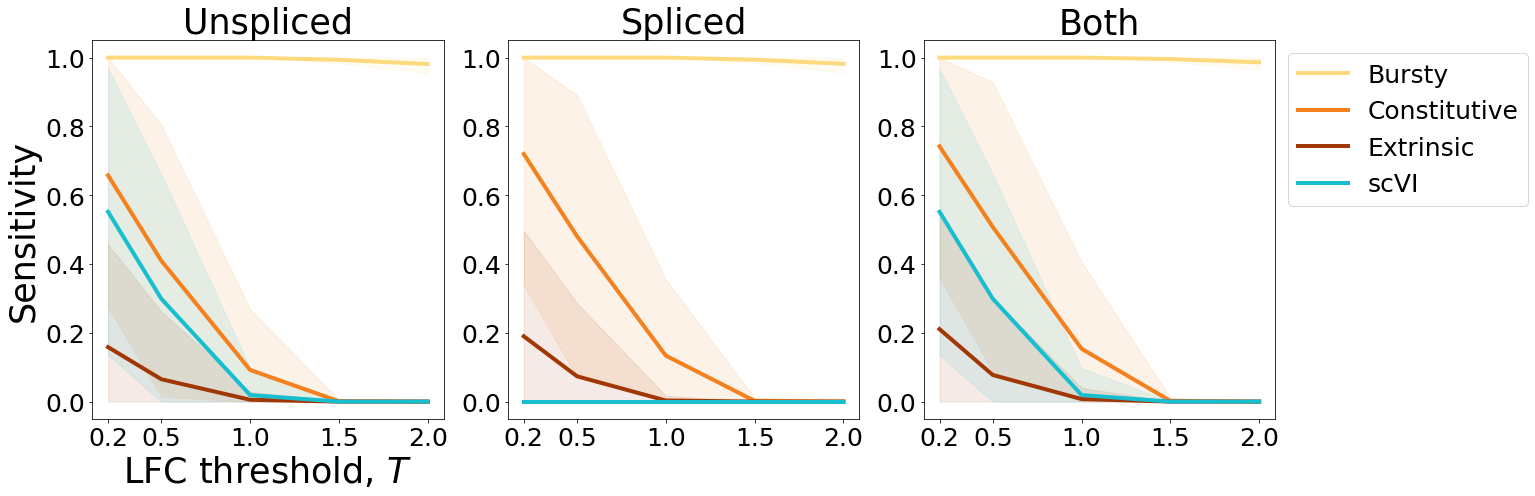

In [46]:
# SENSITIVITY

fig, ax = plt.subplots(1,3,figsize = (18,7))

for i,r in enumerate(RNA):

    values_ = sensitivity_delta_dict[r]
    
    for m,method in enumerate(methods):
        if method == 'scVI, my function':
            pass
        else:
            ax[i].plot(delta_list,values_[m,:,0],color = color_list[m], label = method, linewidth = 4.0)
            ax[i].fill_between(delta_list,[max(values_[m,j,0]-values_[m,j,1],0.0) for j in range(len(methods))],
                           [min(values_[m,j,0]+values_[m,j,1],1.0) for j in range(len(methods))],
                          color = color_list[m], alpha = 0.1)
            ax[i].set_title(r,fontsize = 35)
            ax[i].tick_params('both',labelsize = 25)
            ax[i].set_xticks(delta_list)
            if i == 0:
                ax[i].set_xlabel('LFC threshold, $T$',fontsize = 35)
                ax[i].set_ylabel('Sensitivity',fontsize = 35)
 
plt.tight_layout()
plt.legend(fontsize = 25, bbox_to_anchor = (1.0,1.0))
plt.savefig('../results/bursty_20ct_many_figs/sense_LFC.png',bbox_inches = 'tight');

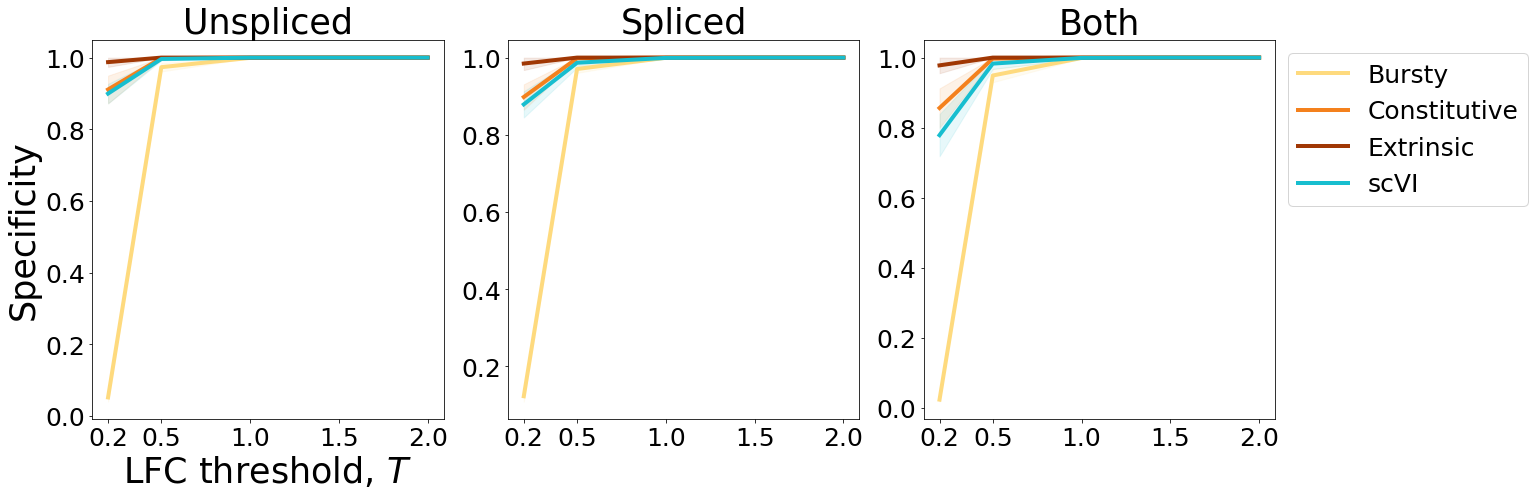

In [47]:
# SPECIFICITY, DELTA
fig, ax = plt.subplots(1,3,figsize = (18,7))

for i,r in enumerate(RNA):

    values_ = specificity_delta_dict[r]
    
    for m,method in enumerate(methods):
        if method == 'scVI, my function':
            pass
        else:   
            ax[i].plot(delta_list,values_[m,:,0],color = color_list[m], label = method, linewidth = 4.0)
            ax[i].fill_between(delta_list,[max(values_[m,j,0]-values_[m,j,1],0.0) for j in range(len(methods))],
                           [min(values_[m,j,0]+values_[m,j,1],1.0) for j in range(len(methods))],
                          color = color_list[m], alpha = 0.1)
            ax[i].set_title(r,fontsize = 35)
            ax[i].tick_params('both',labelsize = 25)
            ax[i].set_xticks(delta_list)
            if i == 0:
                ax[i].set_xlabel('LFC threshold, $T$',fontsize = 35)
                ax[i].set_ylabel('Specificity',fontsize = 35)
 
plt.tight_layout()
plt.legend(fontsize = 25, bbox_to_anchor = (1.0,1.0))
plt.savefig('../results/bursty_20ct_many_figs/spec_LFC.png',bbox_inches = 'tight');

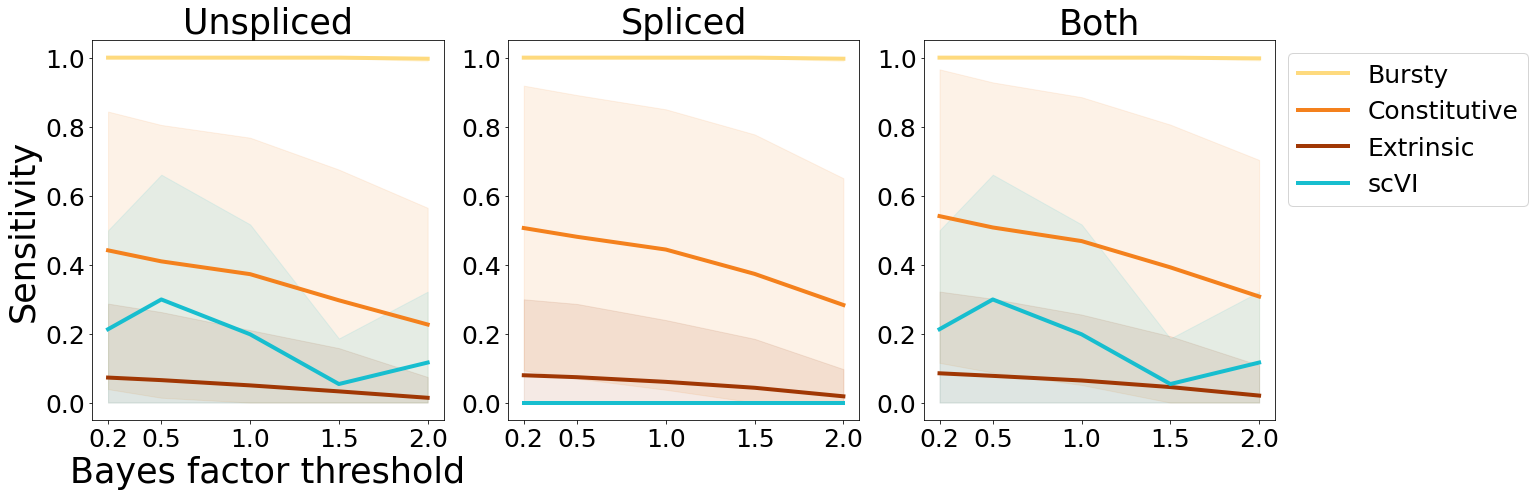

In [48]:
# SENSITIVITY

fig, ax = plt.subplots(1,3,figsize = (18,7))

for i,r in enumerate(RNA):

    values_ = sensitivity_BF_dict[r]
    
    for m,method in enumerate(methods):
        if method == 'scVI, my function':
            pass
        else:
            ax[i].plot(delta_list,values_[m,:,0],color = color_list[m], label = method, linewidth = 4.0)
            ax[i].fill_between(delta_list,
                           [max(values_[m,j,0]-values_[m,j,1],0.0) for j in range(len(methods))],
                           [min(values_[m,j,0]+values_[m,j,1],1.0) for j in range(len(methods))],
                          color = color_list[m], alpha = 0.1)
            ax[i].set_title(r,fontsize = 35)
            ax[i].tick_params('both',labelsize = 25)
            ax[i].set_xticks(delta_list)
            if i == 0:
                ax[i].set_xlabel('Bayes factor threshold',fontsize = 35)
                ax[i].set_ylabel('Sensitivity',fontsize = 35)
 
plt.tight_layout()
plt.legend(fontsize = 25, bbox_to_anchor = (1.0,1.0))
plt.savefig('../results/bursty_20ct_many_figs/sense_BF.png',bbox_inches = 'tight');

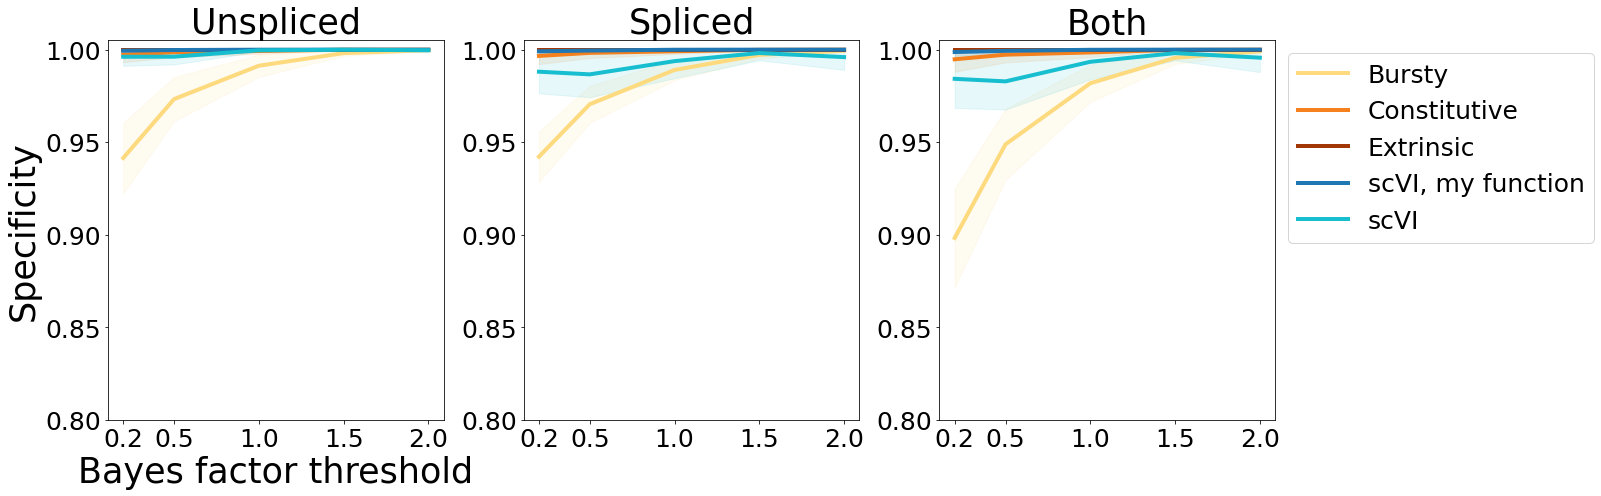

In [49]:
# SPECIFICITY

fig, ax = plt.subplots(1,3,figsize = (18,7))

for i,r in enumerate(RNA):

    values_ = specificity_BF_dict[r]
    
    for m,method in enumerate(methods):
        if method == 'scVI, my function':
            pass
        ax[i].plot(delta_list,values_[m,:,0],color = color_list[m], label = method, linewidth = 4.0)
        ax[i].fill_between(delta_list,values_[m,:,0]-values_[m,:,1],
                           [min(values_[m,j,0]+values_[m,j,1],1.0) for j in range(len(methods))] ,
                          color = color_list[m], alpha = 0.1)

        ax[i].set_title(r,fontsize = 35)
        ax[i].tick_params('both',labelsize = 25)
        ax[i].set_xticks(delta_list)
        ax[i].set_ylim(0.8,1.005)
        if i == 0:
            ax[i].set_xlabel('Bayes factor threshold',fontsize = 35)
            ax[i].set_ylabel('Specificity',fontsize = 35)
 
plt.tight_layout()
plt.legend(fontsize = 25, bbox_to_anchor = (1.0,1.0))
plt.savefig('../results/bursty_20ct_many_figs/spec_BF.png',bbox_inches = 'tight');

----
## Cells per cell type

Could be interesting

In [31]:
MG_per_celltype = []

ct_list = [f'CT{i}' for i in range(20)]

for i in range(20):
    MG_per_celltype.append(sum(adata.var['Marker Annotation'] == i)/2)
    

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


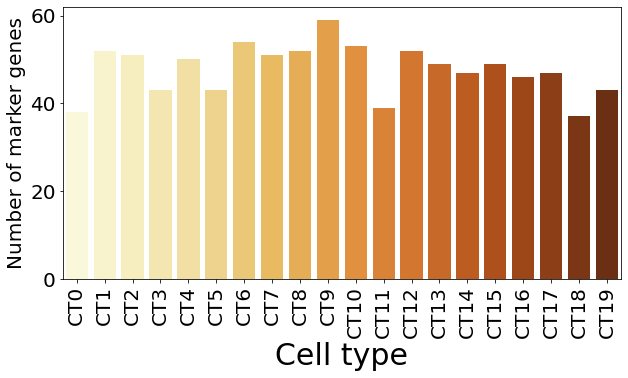

In [46]:
plt.figure(figsize = (10,5))
sns.barplot(ct_list,MG_per_celltype,palette = sns.color_palette("YlOrBr",n_colors=20))
plt.tick_params('both',labelsize = 20)
plt.xticks(rotation = 90)
plt.ylabel('Number of marker genes', fontsize = 20)
plt.xlabel('Cell type',fontsize = 30)
            
            
plt.savefig('../results/bursty_20ct_many_figs/MG_per_ct.png',bbox_inches = 'tight');

# Histogram of Parameters

In [96]:
# set some cell type to look at
ct = 'CT0'
ct_i = 0
idx1 = np.array([cell_types == ct]).flatten()
idx2 = np.array([cell_types != ct]).flatten()
gene = 3

# hyperparameters
n_samples = 10

In [101]:
true_params_u1 = 10**simulated_params[ct_i,i,0]/10**simulated_params[ct_i,i,1]
true_params_s1 = 10**simulated_params[ct_i,i,0]/10**simulated_params[ct_i,i,2]


true_params_u2 = 10**simulated_params[1,i,0]/10**simulated_params[1,i,1]
true_params_s2 = 10**simulated_params[1,i,0]/10**simulated_params[1,i,2]

In [65]:
# biVI
params1b = model1.get_normalized_expression(adata[idx1],
                                          n_samples = n_samples, return_mean = False)
params2b = model1.get_normalized_expression(adata[idx2],
                                            n_samples = n_samples, return_mean = False)

# scVI 
params1v_ = model2.get_normalized_expression(adata[idx1],
                                          n_samples = n_samples, return_mean = False)
params2v_ = model2.get_normalized_expression(adata[idx2],
                                          n_samples = n_samples, return_mean = False)

params1v = {}
params2v = {}
params1v['norm_unspliced_mean'] = params1v_[:,:,:2000]
params1v['norm_spliced_mean'] = params1v_[:,:,2000:]
params2v['norm_unspliced_mean'] = params2v_[:,:,:2000]
params2v['norm_spliced_mean'] = params2v_[:,:,2000:]


# biVI constitutive
params1c = model3.get_normalized_expression(adata[idx1],
                                          n_samples = n_samples, return_mean = False)
params2c = model3.get_normalized_expression(adata[idx2],
                                           n_samples = n_samples, return_mean = False)

# biVI extrinsic
params1e = model4.get_normalized_expression(adata[idx1],
                                          n_samples = n_samples, return_mean = False)
params2e = model4.get_normalized_expression(adata[idx2],
                                            n_samples = n_samples, return_mean = False)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                         

# HISTOGRAMS

Text(0.5, 1.0, 'gene 107')

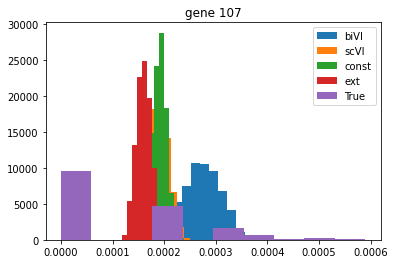

In [104]:
i = 107

true_u1 = adata[idx1,i].X/adata[idx1,:].X.sum(axis=1)
true_u2 =  adata[idx2,i].X/adata[idx2,:].X.sum(axis=1)

true_s1 = adata[idx1,i+2000].X/adata[idx1,:].X.sum(axis=1)
true_s2 =  adata[idx2,i+2000].X/adata[idx2,:].X.sum(axis=1)


plt.hist(params1b['norm_spliced_mean'][:,:,i].flatten(),label='biVI',density=True)
plt.hist(params1v['norm_spliced_mean'][:,:,i].flatten(),label='scVI',density=True)
plt.hist(params1c['norm_spliced_mean'][:,:,i].flatten(),label='const',density=True)
plt.hist(params1e['norm_spliced_mean'][:,:,i].flatten(),label='ext',density=True)

plt.hist(np.array(true_s1).flatten(),label='True',density=True)


plt.legend()
#plt.xlim(0,0.002)
plt.title(f'gene {i}')

Text(0.5, 1.0, 'gene 107')

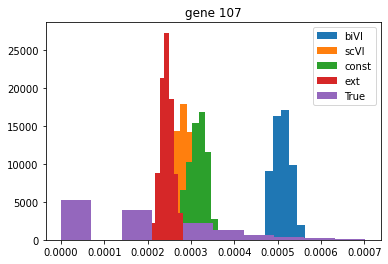

In [88]:


true_u1 = adata[idx1,i].X/adata[idx1,:].X.sum(axis=1)
true_u2 =  adata[idx2,i].X/adata[idx2,:].X.sum(axis=1)

true_s1 = adata[idx1,i+2000].X/adata[idx1,:].X.sum(axis=1)
true_s2 =  adata[idx2,i+2000].X/adata[idx2,:].X.sum(axis=1)


plt.hist(params1b['norm_unspliced_mean'][:,:,i].flatten(),label='biVI',density=True)
plt.hist(params1v['norm_unspliced_mean'][:,:,i].flatten(),label='scVI',density=True)
plt.hist(params1c['norm_unspliced_mean'][:,:,i].flatten(),label='const',density=True)
plt.hist(params1e['norm_unspliced_mean'][:,:,i].flatten(),label='ext',density=True)

plt.hist(np.array(true_u1).flatten(),label='True',density=True)
plt.hist(np.array(true_u1).flatten(),label='True',density=True)

plt.legend()
#plt.xlim(0,0.002)
plt.title(f'gene {i}')

Text(0.5, 1.0, 'gene 107')

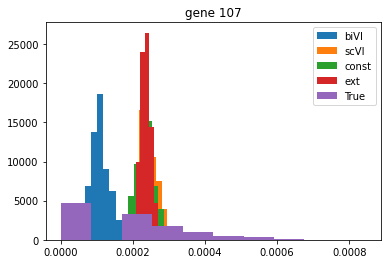

In [89]:
plt.hist(params2b['norm_unspliced_mean'][:,:,i].flatten(),label='biVI',density=True)
plt.hist(params2v['norm_unspliced_mean'][:,:,i].flatten(),label='scVI',density=True)
plt.hist(params2c['norm_unspliced_mean'][:,:,i].flatten(),label='const',density=True)
plt.hist(params2e['norm_unspliced_mean'][:,:,i].flatten(),label='ext',density=True)

plt.hist(np.array(true_u2).flatten(),label='True',density=True)


plt.legend()
#plt.xlim(0,0.002)
plt.title(f'gene {i}')

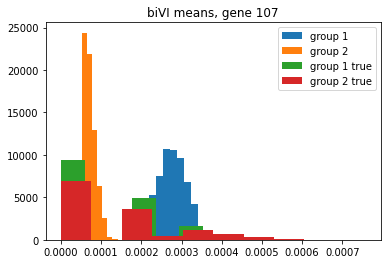

In [90]:
#biVI
plt.hist(params1b['norm_spliced_mean'][:,:,i].flatten(),label='group 1',density=True)
plt.hist(params2b['norm_spliced_mean'][:,:,i].flatten(),label='group 2',density=True)

plt.hist(np.array(true_s1).flatten(),density=True, label = 'group 1 true')
plt.hist(np.array(true_s2).flatten(),density=True, label = 'group 2 true')


plt.title(f'biVI means, gene {i}')
plt.legend()

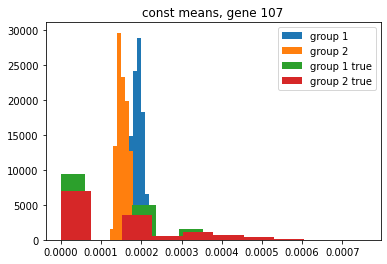

In [91]:
#biVI
plt.hist(params1c['norm_spliced_mean'][:,:,i].flatten(),label='group 1',density=True)
plt.hist(params2c['norm_spliced_mean'][:,:,i].flatten(),label='group 2',density=True)

plt.hist(np.array(true_s1).flatten(),density=True, label = 'group 1 true')
plt.hist(np.array(true_s2).flatten(),density=True, label = 'group 2 true')


plt.title(f'const means, gene {i}')
plt.legend()

In [92]:
adata.var.index[adata.var['Marker Annotation'] == 0]

Index(['8', '145', '187', '206', '209', '212', '264', '317', '404', '420',
       ...
       '3484', '3532', '3536', '3566', '3567', '3584', '3772', '3796', '3825',
       '3967'],
      dtype='object', length=106)